In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%reload_ext rpy2.ipython

In [77]:
import numpy as np
import pandas as pd
import scipy.stats as stats

from kaggle.house_prices import helpers
from kaggle.house_prices import missing
from kaggle.house_prices import outliers
from kaggle.house_prices import transform_numeric as TN
from kaggle.house_prices import api
from kaggle.house_prices.notebook import Plot

from rpy2 import robjects
from rpy2.robjects.lib import ggplot2
robjects.pandas2ri.activate()

combined_dataset = helpers.load_data()
combined_dataset = missing.fix_all(combined_dataset)
combined_dataset = outliers.remove_outliers(combined_dataset)
combined_dataset = (
    combined_dataset
    .assign(
        price_log=lambda df: np.log(df['SalePrice'])
    )
    .drop(columns=['Id', 'SalePrice'])
)

combined_dataset.shape

(2917, 81)

In [3]:
Trans = {
    'log':  lambda x: np.log(x + 1),
    'sqrt': lambda x: np.sqrt(x),
    'inv3': lambda x: x**(1/3),
    'inv4': lambda x: x**(1/4)
}

trans_config = TN.get_transformation_config(
    df=(
        combined_dataset
        .select_dtypes(include=[np.number])
        .drop(columns=['price_log'])
    ),
    trans=Trans
)


trans_config2 = TN.get_transformation_config(
    df=(
        combined_dataset
        .drop(columns=['price_log'])
    ),
    trans=Trans
)

pd.testing.assert_frame_equal(
    trans_config.sort_index(axis=1), 
    trans_config2.sort_index(axis=1)
)

trans_config

,var,progress_score,tran,tran_fn
0,GrLivArea,91.157942,log,<function <lambda> at 0x7f24f8129bf8>
1,X1stFlrSF,90.771657,log,<function <lambda> at 0x7f24f8129bf8>
2,BsmtUnfSF,79.976031,sqrt,<function <lambda> at 0x7f24f7f54950>
3,LotArea,78.864026,inv4,<function <lambda> at 0x7f24f7f549d8>
4,TotRmsAbvGrd,30.685015,log,<function <lambda> at 0x7f24f8129bf8>
5,OverallQual,29.944357,log,<function <lambda> at 0x7f24f8129bf8>
6,GarageCars,24.956765,log,<function <lambda> at 0x7f24f8129bf8>
7,BedroomAbvGr,22.375086,log,<function <lambda> at 0x7f24f8129bf8>
8,OverallCond,16.247239,log,<function <lambda> at 0x7f24f8129bf8>
9,FullBath,12.073778,inv4,<function <lambda> at 0x7f24f7f549d8>


In [4]:
trans_config3 = api.get_functional_transformation_config(
    data=combined_dataset, 
    target="price_log", 
    trans=Trans, 
    threshold=0
)

trans_config3

,var,progress_score,tran,tran_fn,r2_x,r2_tran
0,GrLivArea,91.157942,log,<function <lambda> at 0x7f24f8129bf8>,0.525931,0.543804
3,LotArea,78.864026,inv4,<function <lambda> at 0x7f24f7f549d8>,0.067883,0.159187
4,TotRmsAbvGrd,30.685015,log,<function <lambda> at 0x7f24f8129bf8>,0.289123,0.293868
11,Fireplaces,3.801495,inv4,<function <lambda> at 0x7f24f7f549d8>,0.242062,0.265132


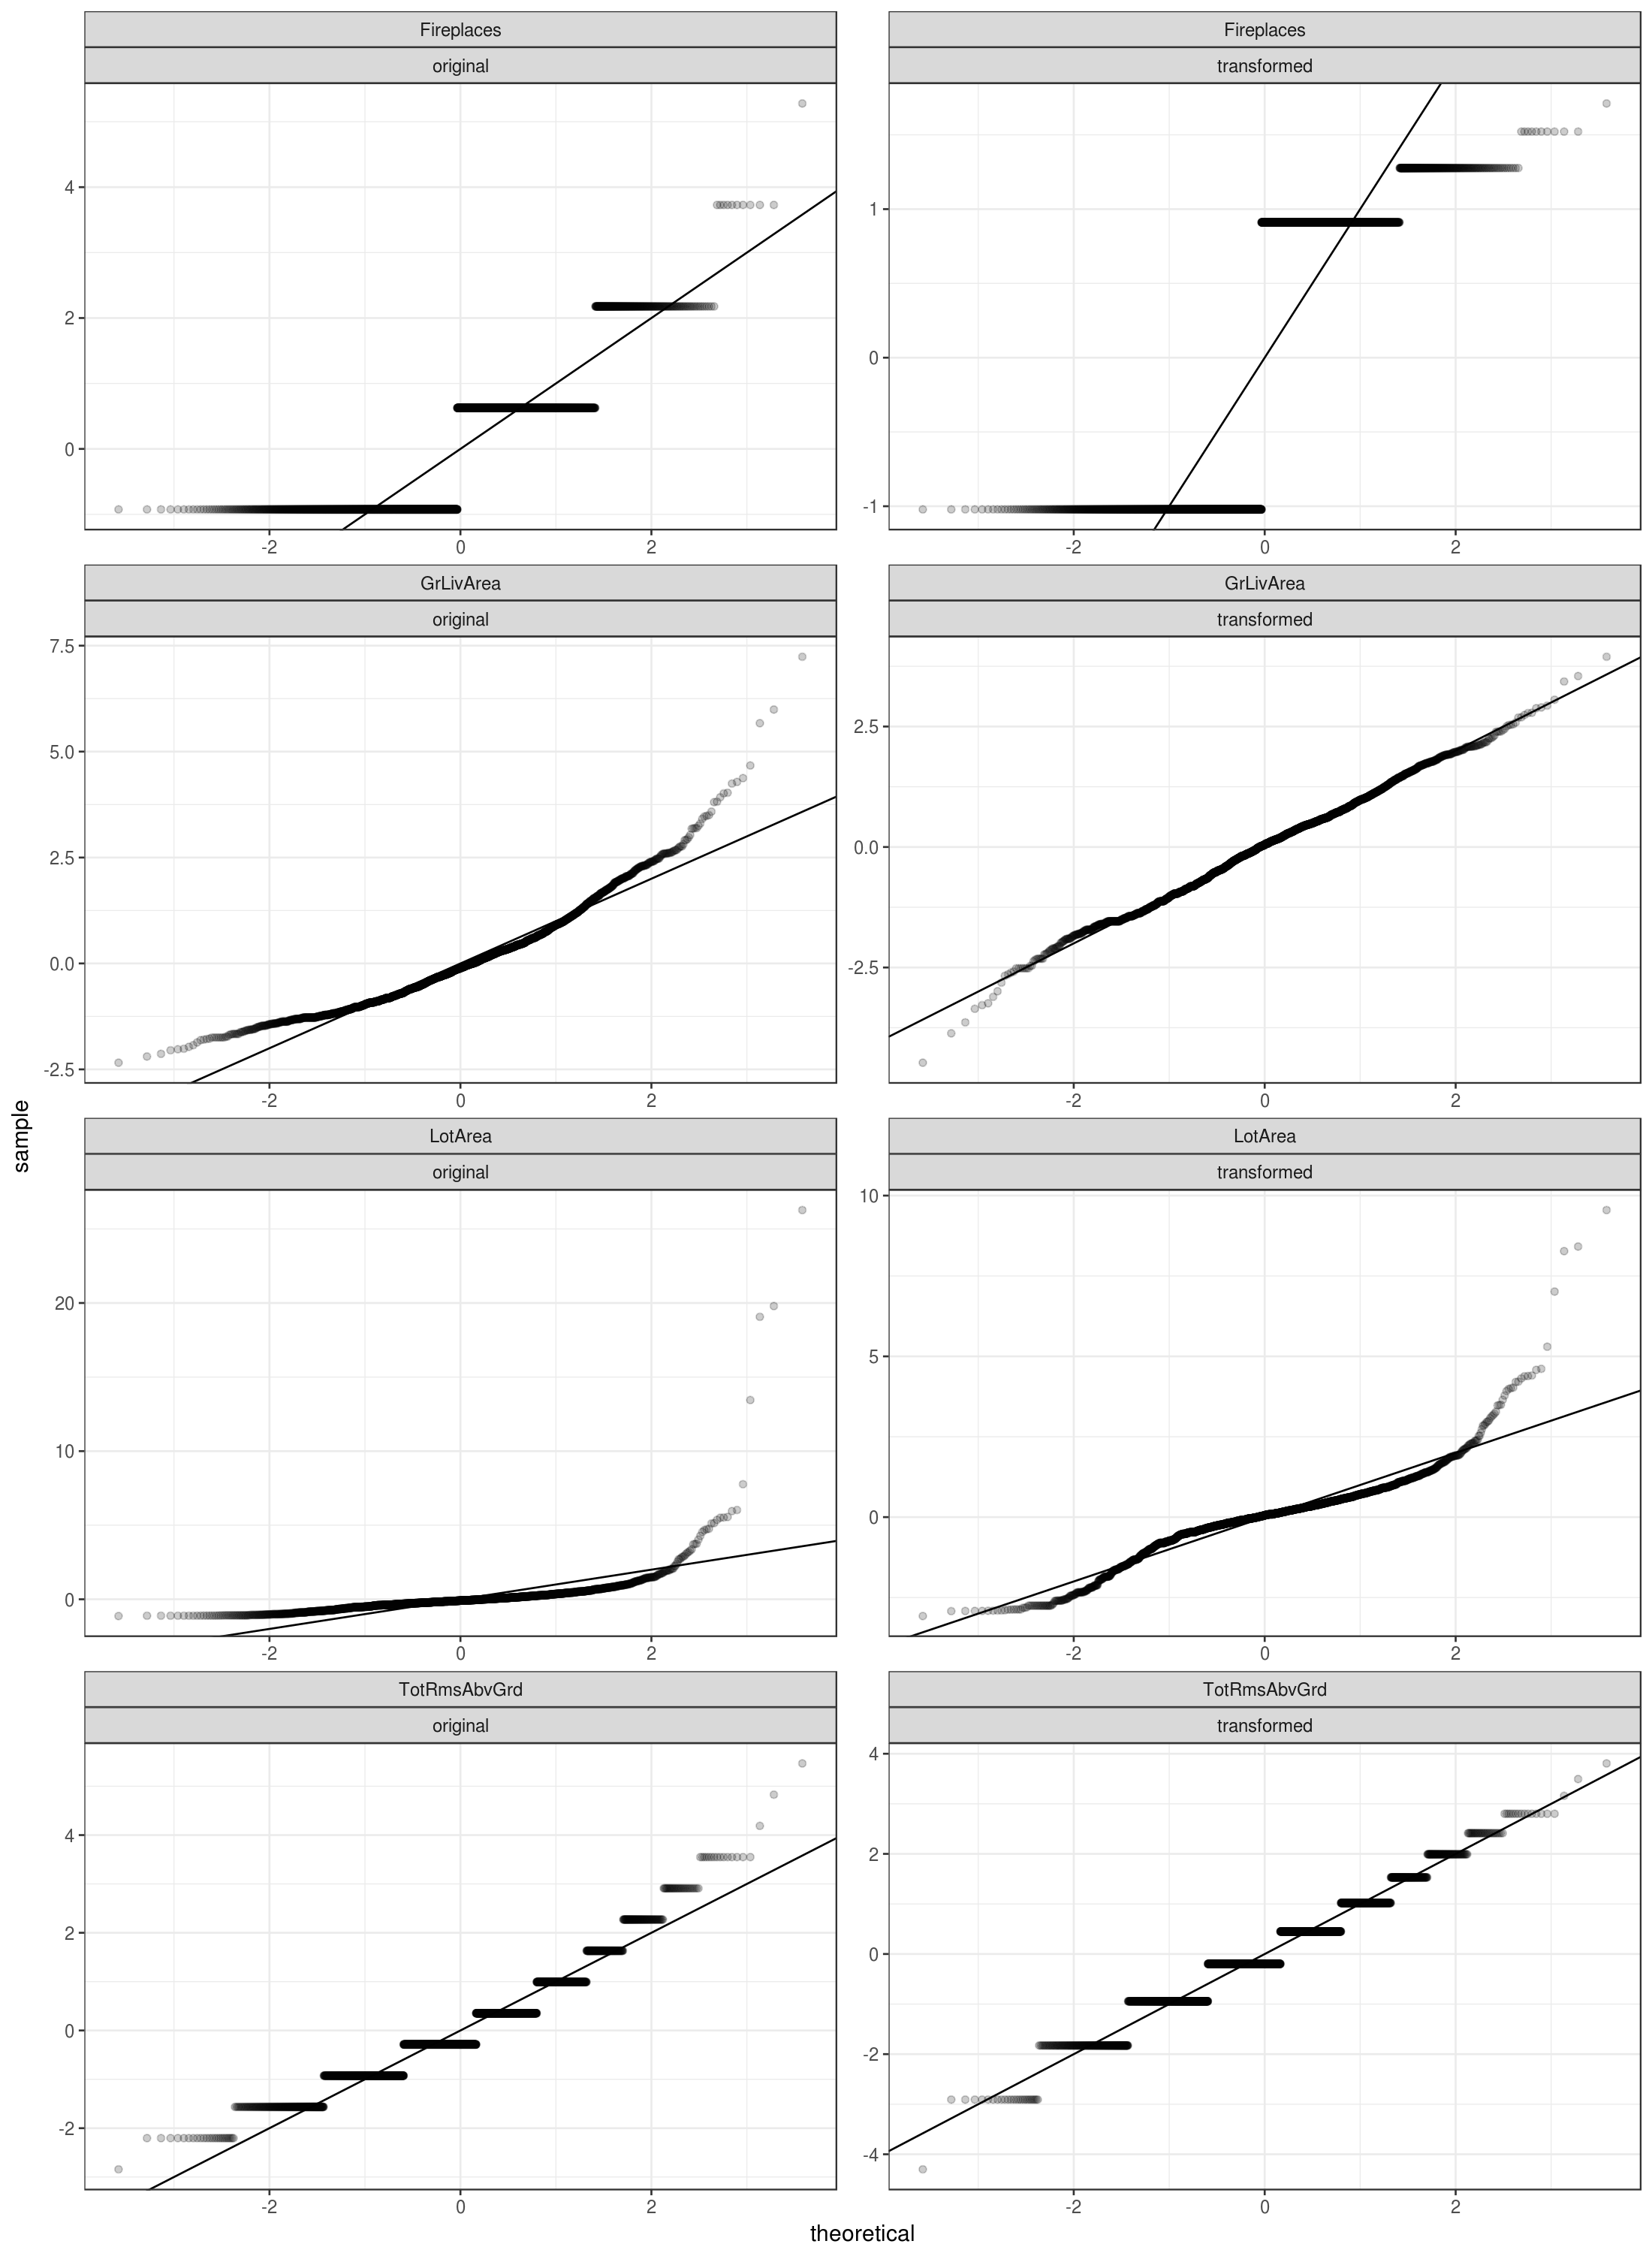

In [81]:
with Plot(width=2200, height=3000, res=180) as plot:
    plot(
        ggplot2.ggplot(
            TN.for_qq_plot(
                data=combined_dataset, 
                trans_config=trans_config3
            )
        ) +
        ggplot2.stat_qq(ggplot2.aes_string(sample="normed_value"), alpha=0.2) +
        ggplot2.facet_wrap(robjects.Formula('var~tran'), ncol=2, scales="free") +
        ggplot2.geom_abline(slope=1) +
        ggplot2.theme_bw()
    )    

In [5]:
transformed_dataset = api.functional_transform(combined_dataset, trans_config3)


pd.testing.assert_series_equal(
    transformed_dataset['GrLivArea'],
    np.log(combined_dataset['GrLivArea'] + 1)
)

pd.testing.assert_series_equal(
    transformed_dataset['LotArea'],
    np.power(combined_dataset['LotArea'], 1/4)
)

pd.testing.assert_frame_equal(
    transformed_dataset.select_dtypes(exclude=[np.number]), 
    combined_dataset.select_dtypes(exclude=[np.number])
)

pd.testing.assert_frame_equal(
    transformed_dataset.select_dtypes(include=[np.number]).drop(columns=trans_config3['var']), 
    combined_dataset.select_dtypes(include=[np.number]).drop(columns=trans_config3['var'])
)